In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def parse_line(line):
    parsed_line = tf.strings.split(line, ',')
    features = tf.strings.to_number(parsed_line[:-1], out_type=tf.float32)
    labels = tf.strings.to_number(parsed_line[-1], out_type=tf.float32)
    return features, labels

# Skiping first 8 lines
skip_rows = 8
file_path = "F:\\Aidin\\Universities\\Amirkabir (Master)\\Lessons\\Term-1\\Neural-Computing & Deep-Learning\\Projects\\My-Answers\\HW1\\data.txt"
dataset = tf.data.TextLineDataset(file_path).skip(skip_rows)
dataset = dataset.map(parse_line)

# Printing the head of dataset that have been read
print(f"{'X1':>10} {'X2':>10} {'Label':>10}")
for features, label in dataset.take(5):
    x1, x2 = features.numpy()
    print(f"{x1:>10.6f} {x2:>10.6f} {label.numpy():>10}")


C:\Program Files\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


        X1         X2      Label
  4.780310   2.698320        0.0
 -2.273710   5.750180        0.0
 -4.817170  -2.209610        0.0
 -9.526940   0.659360        0.0
  1.864400  -5.019510        0.0


In [2]:
total_samples = 0
for _ in dataset:
    total_samples += 1
train_size = int(0.7 * total_samples)
test_size = int(0.2 * total_samples)
validation_size = total_samples - train_size - test_size
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)
validation_dataset = dataset.skip(train_size + test_size)
print(f"Total samples: {total_samples}, Training samples: {train_size}, Test samples: {test_size}, Validation samples: {validation_size}")

Total samples: 4500, Training samples: 3150, Test samples: 900, Validation samples: 450


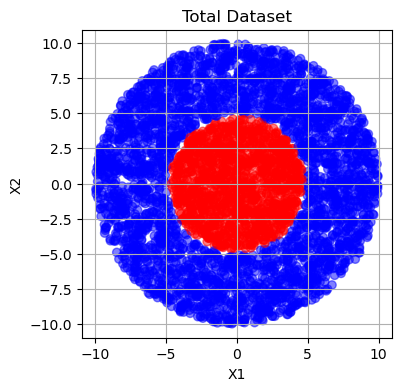

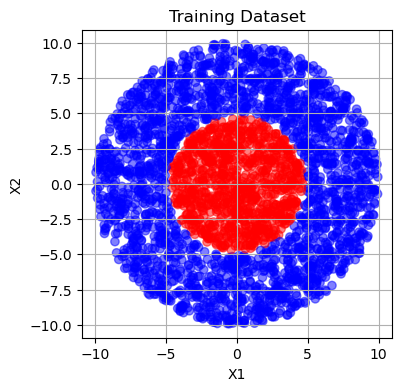

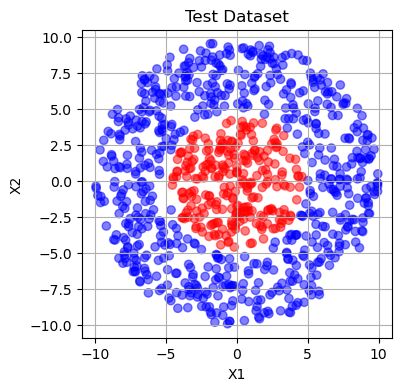

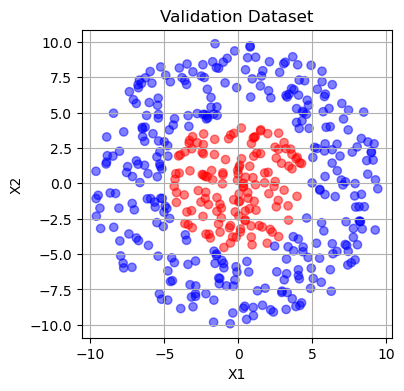

In [3]:
def plot_dataset(dataset, title="Dataset"):
    x, y, color = [], [], []
    for features, label in dataset:
        x1, x2 = features.numpy()
        x.append(x1)
        y.append(x2)
        color.append('blue' if label.numpy() == 0 else 'red')  
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=color, alpha=0.5)
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True)
    plt.show()
dataset = dataset.shuffle(buffer_size=total_samples)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)
validation_dataset = dataset.skip(train_size + test_size)
plot_dataset(dataset, "Total Dataset")
plot_dataset(train_dataset, "Training Dataset")
plot_dataset(test_dataset, "Test Dataset")
plot_dataset(validation_dataset, "Validation Dataset")

In [4]:
def calculate_f1_score(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(int)
    true_positives = np.sum((y_pred_binary == 1) & (y_true == 1))
    predicted_positives = np.sum(y_pred_binary == 1)
    actual_positives = np.sum(y_true == 1)
    precision = true_positives / (predicted_positives + 1e-7)
    recall = true_positives / (actual_positives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1_score

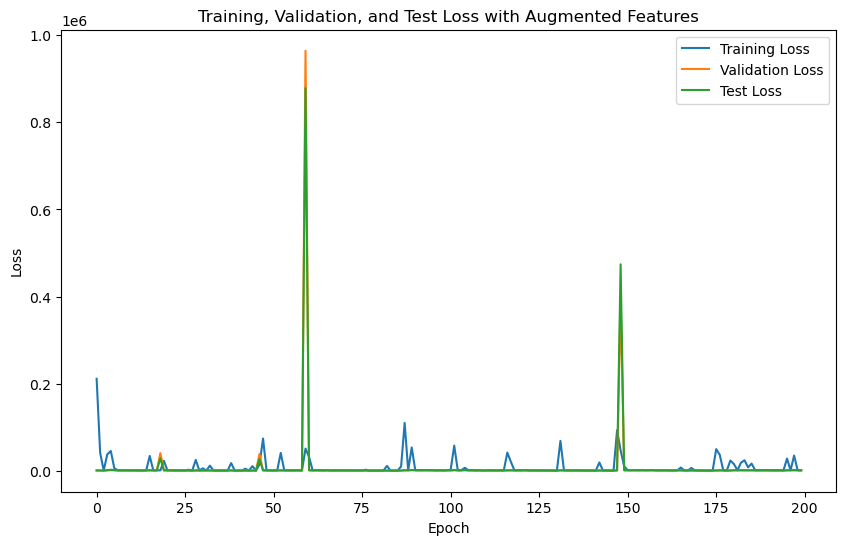

In [11]:
def augment_features(features, label):
    x1, x2 = features[..., 0:1], features[..., 1:2]
    features_squared = tf.square(features)
    features_cubed = tf.pow(features, 3)
    x1_x2 = x1 * x2
    x1_squared_x2_squared = tf.pow(x1, 2) * tf.pow(x2, 2)
    x1_cubed_x2_cubed = tf.pow(x1, 3) * tf.pow(x2, 3)
    augmented_features = tf.concat([features, features_squared, features_cubed, x1_x2, x1_squared_x2_squared, x1_cubed_x2_cubed], axis=-1)
    return augmented_features, label

train_dataset_augmented = train_dataset.map(augment_features)
validation_dataset_augmented = validation_dataset.map(augment_features)
test_dataset_augmented = test_dataset.map(augment_features)
train_dataset_augmented = train_dataset.map(augment_features)
validation_dataset_augmented = validation_dataset.map(augment_features)
test_dataset_augmented = test_dataset.map(augment_features)
model_augmented = tf.keras.Sequential([tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(9,))])
model_augmented.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 200
train_loss_history_augmented = []
validation_loss_history_augmented = []
test_loss_history_augmented = []

for epoch in range(epochs):
    history = model_augmented.fit(train_dataset_augmented.batch(32), epochs=1, verbose=0, validation_data=validation_dataset_augmented.batch(32))
    train_loss_history_augmented.append(history.history['loss'][0])
    validation_loss_history_augmented.append(history.history['val_loss'][0])
    test_loss, *_ = model_augmented.evaluate(test_dataset_augmented.batch(32), verbose=0)
    test_loss_history_augmented.append(test_loss)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history_augmented, label='Training Loss')
plt.plot(validation_loss_history_augmented, label='Validation Loss')
plt.plot(test_loss_history_augmented, label='Test Loss')
plt.title('Training, Validation, and Test Loss with Augmented Features')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


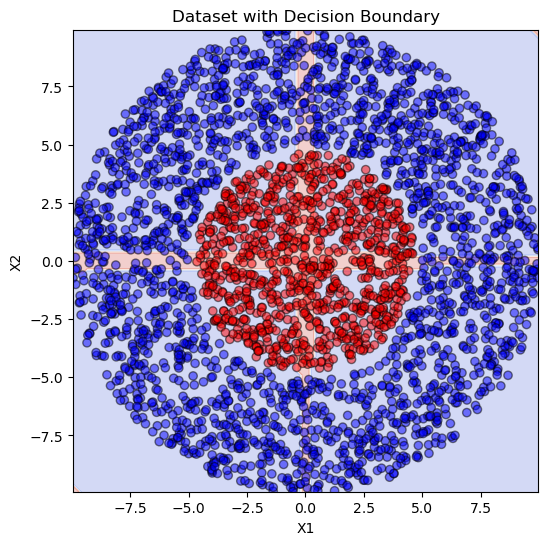

In [12]:
def plot_decision_regions(dataset, model_augmented, batch_size=64):
    x1s, x2s, colors = [], [], []
    for features, label in dataset.batch(batch_size).take(100):
        x1, x2 = features[:, 0].numpy(), features[:, 1].numpy()
        x1s.extend(x1)
        x2s.extend(x2)
        colors.extend(['blue' if lbl == 0 else 'red' for lbl in label.numpy()])
    
    x1_min, x1_max = np.min(x1s), np.max(x1s)
    x2_min, x2_max = np.min(x2s), np.max(x2s)
    x1_range = np.linspace(x1_min, x1_max, 100)
    x2_range = np.linspace(x2_min, x2_max, 100)
    x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
    grid_features = np.stack([x1_grid.flatten(), x2_grid.flatten()], axis=1)
    features_squared = np.square(grid_features)
    features_cubed = np.power(grid_features, 3)   
    x1_x2 = grid_features[:, 0:1] * grid_features[:, 1:2]
    x1_squared_x2_squared = np.square(grid_features[:, 0:1]) * np.square(grid_features[:, 1:2])
    x1_cubed_x2_cubed = np.power(grid_features[:, 0:1], 3) * np.power(grid_features[:, 1:2], 3)
    augmented_features_grid = np.concatenate([grid_features, features_squared, features_cubed, x1_x2, x1_squared_x2_squared, x1_cubed_x2_cubed], axis=1)
    predictions = model_augmented.predict(augmented_features_grid) > 0.5
    plt.figure(figsize=(6, 6))
    plt.contourf(x1_grid, x2_grid, predictions.reshape(x1_grid.shape), alpha=0.25, cmap='coolwarm')
    plt.scatter(x1s, x2s, c=colors, alpha=0.5, edgecolor='k')
    plt.title("Dataset with Decision Boundary")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()

plot_decision_regions(train_dataset_augmented, model_augmented)


In [13]:
test_dataset_batch = test_dataset_augmented.batch(32)
y_true = np.concatenate([y.numpy() for _, y in test_dataset_batch])
y_pred_prob = model_augmented.predict(test_dataset_batch)
y_pred_binary = (y_pred_prob > 0.5).astype(int)
f1 = calculate_f1_score(y_true, y_pred_binary)
print(f"F1-Score: {f1}")
accuracy_0 = np.sum((y_pred_binary == 0) & (y_true == 0)) / np.sum(y_true == 0)
accuracy_1 = np.sum((y_pred_binary == 1) & (y_true == 1)) / np.sum(y_true == 1)
print(f"Accuracy for class 0: {accuracy_0:.4f}")
print(f"Accuracy for class 1: {accuracy_1:.4f}")
weights, bias = model_augmented.layers[0].get_weights()
print(f"Weights: {weights.flatten()}")
print(f"Bias: {bias}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
F1-Score: 130.4109587969225
Accuracy for class 0: 815.0000
Accuracy for class 1: 85.0000
Weights: [  -0.49339122    1.037203     40.17934      33.926388     -3.1603978
    1.791272     -3.5767028  -305.47974       3.1827703 ]
Bias: [39.854736]
